<a href="https://colab.research.google.com/github/JangAyeon/ToBigs/blob/master/%5B6%5DNeuralNetworkBasic_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 6) Neural Network Basic 과제

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

## 데이터 불러오기

#### 데이터셋: CIFAR-10
- 32x32 픽셀의 60,000개 컬러이미지
- 10개의 클래스로 라벨링 되어있음

![image.png](attachment:9602b2f5-a9de-4411-acb4-7df5f1ea4c1a.png)

In [ ]:
x_train = np.load("./x_train_data.npy")
y_train = np.load("./y_train_data.npy")
x_test = np.load("./x_test_data.npy")
y_test = np.load("./y_test_data.npy")

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5000, 3072), (5000,), (1000, 3072), (1000,))

## Activation Function

### Sigmoid Function

In [ ]:
class sigmoid:
    # sigmoid 함수입니다.
    def forward(x):
        return 1 / (1+np.exp(-x))
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(x):
        return x*(1-x)

In [ ]:
a = np.array([-1,2,3])

In [ ]:
sigmoid.forward(a)

array([0.26894142, 0.88079708, 0.95257413])

In [ ]:
sigmoid.backward(a)

array([-2, -2, -6])

### ReLU

In [ ]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
        return np.maximum(0,x)
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        return np.where(x>0,1,0)

In [ ]:
relu.forward(a)

array([0, 2, 3])

In [ ]:
relu.backward(a)

array([0, 1, 1])

### Output Activation Function

In [ ]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            # print("z", z[0])
            c = np.max(zi) 
            #최대값 대입
            exp_zi = np.exp(zi-c) 
            #exp 계산 중에 오버플로우가 발생할 수 있어 최대값을 빼고 exp를 계산
            #softmax는 수를 더하건 빼건 그 결과가 같기 때문에 가능 
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)
            # print("y", y[0])
        # print(y[0])
        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

In [ ]:
z = np.array([[np.log(1), np.log(3), np.log(4)]])
p = np.array([[0.125, 0.375, 0.5]])
y = np.array([2])

In [ ]:
softmax.forward(z)

array([[0.125, 0.375, 0.5  ]])

In [ ]:
softmax.backward(p, y)

array([[ 0.125,  0.375, -0.5  ]])

## Loss Function

### Cross Entropy
$-\Sigma(yk   log (pk))=-log pi,(1<=i<=k)$

In [ ]:
def cross_entropy(p, y):
    # cross entropy 함수를 작성하세요
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k]) + 1e-8)) 
                # 1e-8은 무한대로 발산하는 경우를 방지하기 위해 존재합니다
    return loss

In [ ]:
cross_entropy(p, y)

[0.6931471705599452]

## Layer

In [ ]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std # std는 가중치 초기화에서 표준편차를 줄이기 위해 존재합니다

## Neural Network

각 메소드와 변수의 역할을 주석으로 달아주세요.

In [ ]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
        self.lr = lr 
        #learning rate
        self.epoch = epoch 
        #모든 데이터에 대해서 forward, backward가 진행되는 세트가 총 몇개인지
        self.batch_size = batch_size
        #한 번 batch 당 할당되는 데이터의 사이즈
        self.loss_function = cross_entropy 
        # mse로 대체 가능하지만 이번 과제는 분류이므로 cross_entropy로 넣었습니다
        self.layers = []
        #말 그대로..레이어...층..
        self.activations = [softmax]
        #활성화 함수. 여기서는 softmax 사용
        self.nodes = []
        #각 레이어에서의 노드
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer)
        if not self.nodes: #노드가 비어있으면
            self.nodes.append(np.zeros(Layer.input_size)) 
            #input_size값만큼 넣음
        self.nodes.append(np.zeros(Layer.output_size))
        #노드가 비어있지 않음 -> output_size만큼 넣음
    
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation):
        tmp = self.activations.pop()
        self.activations.append(Activation)
        self.activations.append(tmp)
        
    # 순전파 함수
    def _forward(self, X):
        self.nodes[0] = X.copy()
        output = X.copy()
        for i in range(len(self.layers)):
            Layer = self.layers[i] #해당 레이어 정보 할당 (특히 가중치)
            Activation = self.activations[i] #할성화 함수 정보 할당
            output = np.dot(self.nodes[i], Layer.weight) #노드값 * 가중치
            output = output+ Layer.bias #노드값 * 가중치 + bias
            output = Activation.forward(output)
            #노드값 * 가중치 + bias를 활성화 함수에 입력
            self.nodes[i+1] = output 
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))):
            a = self.nodes[i+1]
            Layer = self.layers[i]
            Activation = self.activations[i]
            if i+1 == len(self.layers):
                error = Activation.backward(output, y)
            else:
                error *= Activation.backward(a)
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0]
            #가중치 업데이트 : weight = weight - 오차값 * 노드값 *learning rate/크기
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0]
            error = np.dot(error, Layer.weight.T)
            #업데이트된 가중치와 기저값으로 새로운 오차 구함
    
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1)
        return np.sum(pre_p==y)/y.shape[0]
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in range(self.epoch):
            for j in range(N//self.batch_size):
                batch_mask = np.random.choice(N, self.batch_size)
                X_batch = X[batch_mask]
                y_batch = y[batch_mask]
                output = self._forward(X_batch) #순전파
                self._backward(X_batch, output, y_batch) #역전파
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X)
            history["val_acc"].append(self._accuracy(output, val_y)) #accuracy 기록
            history["val_loss"].append(sum(self.loss_function(output, val_y))) #loss 기록
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 50 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

#**시도 [1]**<br>

Learning Rate : 0.0005<br>
Epoch : 85<br>
Batch_Size : 400<br>

1st layer : (3072,1500)<br>
Activation Function : Sigmoid<br>
2nd layer : (1500,10)<br><br>

Best Validation Accuracy :  0.359

In [ ]:
# 하이퍼 파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.0005, epoch=85, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(3072,1500))
nn.addActivation(sigmoid)
nn.addLayer(Layer(1500,10))

In [ ]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(3072, 1500) (1500,)
(1500, 10) (10,)


In [ ]:
history = nn.fit(x_train, y_train, x_test, y_test)

0 test accuracy : 0.102
0 test loss     : 2536.020482169141
50 test accuracy : 0.317
50 test loss     : 1953.1577378283512


## Accuracy 그래프

학습한 결과를 그래프로 그려보고 높은 Accuracy를 노려보세요!

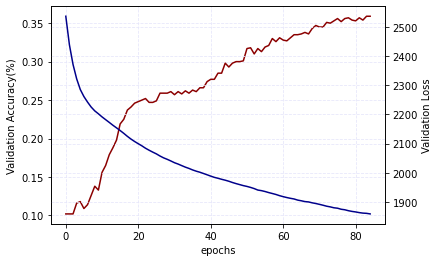

Best Validation Accuracy :  0.359


In [ ]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

# 에포크 숫자만큼 range(epoch)를 변경해주셔야 합니다~
ax_acc.plot(range(85), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(85), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))

#**시도 [2]**<br>

Learning Rate : 0.0005<br>
Epoch : 85<br>
Batch_Size : 400<br>

1st layer : (3072,2000)<br>
Activation Function : Sigmoid<br>
2nd layer : (2000,10)<br><br>

Best Validation Accuracy :  0.362

In [ ]:
# 하이퍼 파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.0005, epoch=85, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(3072,2000)) #
nn.addActivation(sigmoid)
nn.addLayer(Layer(2000,10))

In [ ]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(3072, 2000) (2000,)
(2000, 10) (10,)


In [ ]:
history = nn.fit(x_train, y_train, x_test, y_test)

0 test accuracy : 0.09
0 test loss     : 2738.7524316374747
50 test accuracy : 0.328
50 test loss     : 1923.359457926387


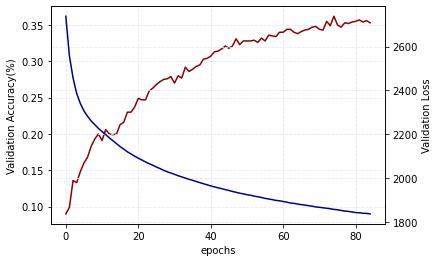

Best Validation Accuracy :  0.362


In [ ]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

# 에포크 숫자만큼 range(epoch)를 변경해주셔야 합니다~
ax_acc.plot(range(85), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(85), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))

#**시도 [3]**<br>

Learning Rate : 0.0005<br>
Epoch : 85<br>
Batch_Size : 400<br>

1st layer : (3072,2000)<br>
Activation Function : Relu<br>
2nd layer : (2000,10)<br><br>

Best Validation Accuracy :  0.442

In [ ]:
# 하이퍼 파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.0005, epoch=85, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(3072,2000)) #
nn.addActivation(relu)
nn.addLayer(Layer(2000,10))

In [ ]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(3072, 2000) (2000,)
(2000, 10) (10,)


In [ ]:
history = nn.fit(x_train, y_train, x_test, y_test)

0 test accuracy : 0.172
0 test loss     : 2275.3605494031935
50 test accuracy : 0.409
50 test loss     : 1610.064558163371


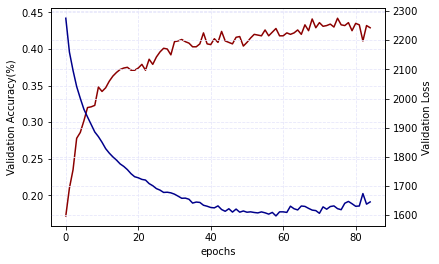

Best Validation Accuracy :  0.442


In [ ]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

# 에포크 숫자만큼 range(epoch)를 변경해주셔야 합니다~
ax_acc.plot(range(85), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(85), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))

#**시도 [4]**<br>

Learning Rate : 0.0005<br>
Epoch : 85<br>
Batch_Size : 400<br>

1st layer : (3072,1500)<br>
Activation Function : Sigmoid<br>
2nd layer : (1500,500)<br><br>
Activation Function : Sigmoid<br>
3rd layer : (500,10)<br><br>

Best Validation Accuracy :  0.112

In [ ]:
# 하이퍼 파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.0005, epoch=85, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(3072,1500)) #
nn.addActivation(sigmoid)
nn.addLayer(Layer(1500,500))
nn.addActivation(sigmoid)
nn.addLayer(Layer(500,10))

In [ ]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(3072, 1500) (1500,)
(1500, 500) (500,)
(500, 10) (10,)


In [ ]:
history = nn.fit(x_train, y_train, x_test, y_test)

0 test accuracy : 0.089
0 test loss     : 2555.8650478498244
50 test accuracy : 0.112
50 test loss     : 2302.4970147426448


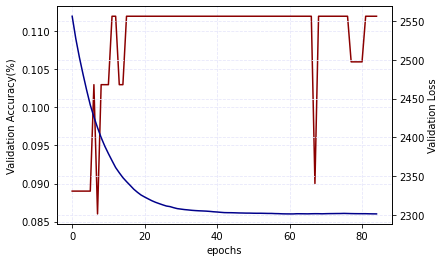

Best Validation Accuracy :  0.112


In [ ]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

# 에포크 숫자만큼 range(epoch)를 변경해주셔야 합니다~
ax_acc.plot(range(85), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(85), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))

#**시도 [5]**<br>

Learning Rate : 0.0005<br>
Epoch : 85<br>
Batch_Size : 400<br>

1st layer : (3072,2000)<br>
Activation Function : relu<br>
2nd layer : (1500,2000)<br><br>
Activation Function : relu<br>
3rd layer : (500,10)<br><br>

Best Validation Accuracy :  0.152

In [ ]:
# 하이퍼 파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.0005, epoch=85, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(3072,2000)) #
nn.addActivation(relu)
nn.addLayer(Layer(2000,500))
nn.addActivation(relu)
nn.addLayer(Layer(500,10))

In [ ]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(3072, 2000) (2000,)
(2000, 500) (500,)
(500, 10) (10,)


In [ ]:
history = nn.fit(x_train, y_train, x_test, y_test)

0 test accuracy : 0.103
0 test loss     : 2535.640170741725
50 test accuracy : 0.135
50 test loss     : 2296.6228761856623


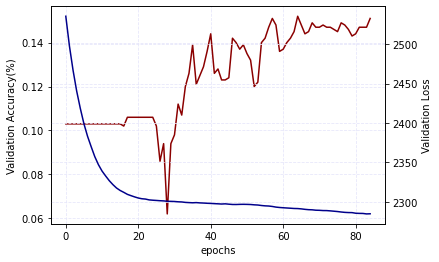

Best Validation Accuracy :  0.152


In [ ]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

# 에포크 숫자만큼 range(epoch)를 변경해주셔야 합니다~
ax_acc.plot(range(85), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(85), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))

#**시도 [6]**<br>

Learning Rate : 0.0005<br>
Epoch : 85<br>
Batch_Size : 400<br>

1st layer : (3072,2000)<br>
Activation Function : relu<br>
2nd layer : (1500,2000)<br><br>
Activation Function : sigmoid<br>
3rd layer : (500,10)<br><br>

Best Validation Accuracy : 0.17

In [ ]:
# 하이퍼 파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.0005, epoch=85, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(3072,2000)) #
nn.addActivation(relu)
nn.addLayer(Layer(2000,500))
nn.addActivation(sigmoid)
nn.addLayer(Layer(500,10))

In [ ]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(3072, 2000) (2000,)
(2000, 500) (500,)
(500, 10) (10,)


In [ ]:
history = nn.fit(x_train, y_train, x_test, y_test)

0 test accuracy : 0.112
0 test loss     : 2616.514403352464
50 test accuracy : 0.14
50 test loss     : 2300.5867533524975


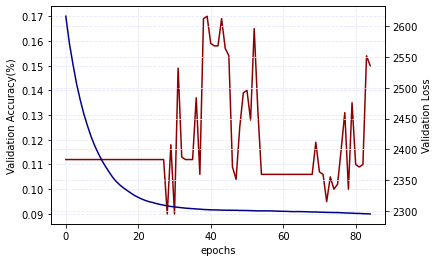

Best Validation Accuracy :  0.17


In [ ]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

# 에포크 숫자만큼 range(epoch)를 변경해주셔야 합니다~
ax_acc.plot(range(85), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(85), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))

#**[Best Model]**

Learning Rate : 0.0005<br>
Epoch : 85<br>
Batch_Size : 400<br>

1st layer : (3072,2000)<br>
Activation Function : Relu<br>
2nd layer : (2000,10)<br><br>

Best Validation Accuracy :  0.442